# **Pricing Model Creation and Booking Frequency Analysis Using Snowflake and Python**

## **Introduction**
This notebook outlines the implementation of a dynamic pricing model and booking frequency analysis for hotel rooms using Snowflake as the database platform. The process involves retrieving data from Snowflake, optimizing room rates based on demand, and analyzing booking trends.

We will utilize the following Python libraries:
- `snowflake-snowpark-python`
- `pandas`
- `numpy`
- `scipy`

### **Steps Overview**:

1. **Data Retrieval**: 
   - The notebook connects to the Snowflake session using a predefined utility function `get_session()` from the `fosforml.model_manager.snowflakesession` package.
   - This connection allows for the extraction of room-related data from Snowflake tables for further analysis.

2. **Pricing Model Construction**: 
   - A pricing model is built to forecast optimal room rates based on historical booking data.
   - The model utilizes the `scipy.optimize` functions to fit demand curves and determine the optimal pricing strategy. 
   - Key operations include:
     - Retrieving historical booking and room data.
     - Calculating demand as a function of price.
     - Fitting demand curves for different room types, hotels, and time periods.
     - Optimizing room rates to maximize expected revenue.

3. **Booking Data Expansion and Frequency Analysis**: 
   - Booking data is expanded to generate individual rows for each stay date.
   - This expanded data is grouped by hotel, room type, market segment, and more, allowing for an analysis of booking frequency and the average daily rate (`adr`).

4. **Data Storage**: 
   - The final processed data, including pricing and booking frequency results, is written back to Snowflake.
   - These results can be used for downstream processes such as further analysis or reporting.

Values as of sep 9th

City Hotel	A	150
Resort Hotel	A	150
Resort Hotel	D	75
Resort Hotel	E	60
City Hotel	D	80
City Hotel	E	30

OLD start_date = '2022-05-01'
OLD end_date = '2024-06-30'

start_date = '2022-12-02'
end_date = '2025-01-31'

### **Package Installation**

To ensure all the necessary packages are installed, run the following commands:

In [1]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install fosforml==1.1.6

     |████████████████████████████████| 1.8MB 8.1MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 202.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 237.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 170.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 152.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 233.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 161.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 184.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 216.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 193.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━


### **Imports and Configurations**

In [2]:
from fosforml import *
from fosforml.constants import MLModelFlavours
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

# **Snowflake Session Initialization**

In [3]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

### **SQL Query to Retrieve the table BOOKINGS_TRANSFORMED**

In [4]:
# Define the table name
table_name = 'BOOKINGS_TRANSFORMED'

# Execute SQL query to retrieve the data from the specified table
data = my_session.sql("select * from {}".format(table_name))

# Convert the Snowflake DataFrame to a pandas DataFrame for easier manipulation and analysis
data = data.to_pandas()

# Display the data
data

,HOTEL,IS_CANCELED,LEAD_TIME,RESERVATION_STATUS,TOTAL_STAY_NIGHTS,TALLY_DAYS,STAYS_IN_WEEKEND_NIGHTS,STAYS_IN_WEEK_NIGHTS,ADULTS,CHILDREN,BABIES,TOTAL_GUESTS,AVG_ROOMS_PER_NIGHT,TOTAL_ROOM_NIGHTS,MEAL,COUNTRY,MARKET_SEGMENT,DISTRIBUTION_CHANNEL,PREVIOUS_CANCELLATIONS,PREVIOUS_BOOKINGS_NOT_CANCELED,RESERVED_ROOM_TYPE,ASSIGNED_ROOM_TYPE,DEPOSIT_TYPE,DAYS_IN_WAITING_LIST,CUSTOMER_TYPE,ADR,ARRIVAL_DATE_TRANSFORMED,RESERVATION_STATUS_DATE_TRANSFORMED
0,City Hotel,0,226,Check.Out,4,4.000,2,2,2,0,0,2,1,4,BB,FRA,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient.Party,70.00,2024-03-31,2023-08-18
1,Resort Hotel,1,210,Canceled,7,0.183,2,5,2,0,0,2,1,7,HB,PRT,Offline TA/TO,TA/TO,0,0,E,E,No Deposit,0,Transient,90.00,2024-10-04,2024-03-08
2,City Hotel,1,127,Canceled,3,0.100,2,1,2,0,0,2,1,3,SC,BRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,79.20,2024-04-14,2023-12-09
3,Resort Hotel,0,93,Check.Out,6,6.000,2,4,2,0,0,2,1,6,HB,AUT,Online TA,TA/TO,0,0,E,E,No Deposit,0,Transient,102.93,2024-03-29,2023-12-27
4,Resort Hotel,0,18,Check.Out,1,1.000,0,1,2,0,0,2,1,1,BB,ESP,Online TA,TA/TO,0,0,E,E,No Deposit,0,Transient.Party,80.00,2024-04-03,2024-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109613,City Hotel,0,81,Check.Out,3,3.000,2,1,2,0,0,2,1,3,BB,IRL,Direct,Direct,0,0,A,A,No Deposit,0,Transient,79.80,2024-04-01,2024-01-11
109614,City Hotel,0,18,Check.Out,3,3.000,2,1,2,0,0,2,1,3,SC,BEL,Online TA,GDS,0,0,E,E,No Deposit,0,Transient,145.00,2024-04-01,2024-03-14
109615,City Hotel,0,47,Check.Out,2,2.000,1,1,2,0,0,2,1,2,BB,PRT,Direct,Direct,0,0,E,E,No Deposit,0,Transient,135.44,2024-04-02,2024-02-15
109616,City Hotel,1,72,Canceled,4,0.470,1,3,2,0,0,2,1,4,SC,FRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,74.80,2024-05-21,2024-03-10


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109618 entries, 0 to 109617
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   HOTEL                                109618 non-null  object 
 1   IS_CANCELED                          109618 non-null  int8   
 2   LEAD_TIME                            109618 non-null  int16  
 3   RESERVATION_STATUS                   109618 non-null  object 
 4   TOTAL_STAY_NIGHTS                    109618 non-null  int8   
 5   TALLY_DAYS                           109618 non-null  float64
 6   STAYS_IN_WEEKEND_NIGHTS              109618 non-null  int8   
 7   STAYS_IN_WEEK_NIGHTS                 109618 non-null  int8   
 8   ADULTS                               109618 non-null  int8   
 9   CHILDREN                             109618 non-null  int8   
 10  BABIES                               109618 non-null  int8   
 11  TOTAL_GUESTS 

In [6]:
# Convert all column names to lowercase
data.columns = map(lambda x: str(x).lower(), data.columns)

# removing Canceletions and no-shows and keep City hotel data only


# **Data Preparation - Price Update Function**

In [7]:
def update_values(row):
    """
    Assigns a price based on hotel type and reserved room type.

    Parameters:
    row (pd.Series): A row of the DataFrame containing 'hotel' and 'reserved_room_type' columns.

    Returns:
    int or None: The assigned price based on the conditions or None if no match is found.
    """
    if row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'A':
        return 150
    elif row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'D':
        return 80
    elif row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'E':
        return 30
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'A':
        return 150
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'D':
        return 75
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'E':
        return 60
    else:
        return None  # Explicitly return None for rows that don't match any condition



# **Data Preparation - Applying the Price Update Function**

In [8]:
# Apply the update_values function to each row of the DataFrame
data['room_limit'] = data.apply(update_values, axis=1)
data

,hotel,is_canceled,lead_time,reservation_status,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,arrival_date_transformed,reservation_status_date_transformed,room_limit
0,City Hotel,0,226,Check.Out,4,4.000,2,2,2,0,0,2,1,4,BB,FRA,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient.Party,70.00,2024-03-31,2023-08-18,150
1,Resort Hotel,1,210,Canceled,7,0.183,2,5,2,0,0,2,1,7,HB,PRT,Offline TA/TO,TA/TO,0,0,E,E,No Deposit,0,Transient,90.00,2024-10-04,2024-03-08,60
2,City Hotel,1,127,Canceled,3,0.100,2,1,2,0,0,2,1,3,SC,BRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,79.20,2024-04-14,2023-12-09,150
3,Resort Hotel,0,93,Check.Out,6,6.000,2,4,2,0,0,2,1,6,HB,AUT,Online TA,TA/TO,0,0,E,E,No Deposit,0,Transient,102.93,2024-03-29,2023-12-27,60
4,Resort Hotel,0,18,Check.Out,1,1.000,0,1,2,0,0,2,1,1,BB,ESP,Online TA,TA/TO,0,0,E,E,No Deposit,0,Transient.Party,80.00,2024-04-03,2024-03-16,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109613,City Hotel,0,81,Check.Out,3,3.000,2,1,2,0,0,2,1,3,BB,IRL,Direct,Direct,0,0,A,A,No Deposit,0,Transient,79.80,2024-04-01,2024-01-11,150
109614,City Hotel,0,18,Check.Out,3,3.000,2,1,2,0,0,2,1,3,SC,BEL,Online TA,GDS,0,0,E,E,No Deposit,0,Transient,145.00,2024-04-01,2024-03-14,30
109615,City Hotel,0,47,Check.Out,2,2.000,1,1,2,0,0,2,1,2,BB,PRT,Direct,Direct,0,0,E,E,No Deposit,0,Transient,135.44,2024-04-02,2024-02-15,30
109616,City Hotel,1,72,Canceled,4,0.470,1,3,2,0,0,2,1,4,SC,FRA,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,74.80,2024-05-21,2024-03-10,150


In [9]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'reservation_status',
       'total_stay_nights', 'tally_days', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'total_guests',
       'avg_rooms_per_night', 'total_room_nights', 'meal', 'country',
       'market_segment', 'distribution_channel', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'adr', 'arrival_date_transformed',
       'reservation_status_date_transformed', 'room_limit'],
      dtype='object')

# **Data Filtering - Excluding Canceled and No-Show Reservations**

In [10]:
# Filter the DataFrame to include only non-canceled and confirmed reservations
df = data[(data['is_canceled'] == 0) & (data['reservation_status'] !='No-Show')] 
# Display the filtered DataFrame
df

,hotel,is_canceled,lead_time,reservation_status,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,arrival_date_transformed,reservation_status_date_transformed,room_limit
0,City Hotel,0,226,Check.Out,4,4.0,2,2,2,0,0,2,1,4,BB,FRA,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient.Party,70.00,2024-03-31,2023-08-18,150
3,Resort Hotel,0,93,Check.Out,6,6.0,2,4,2,0,0,2,1,6,HB,AUT,Online TA,TA/TO,0,0,E,E,No Deposit,0,Transient,102.93,2024-03-29,2023-12-27,60
4,Resort Hotel,0,18,Check.Out,1,1.0,0,1,2,0,0,2,1,1,BB,ESP,Online TA,TA/TO,0,0,E,E,No Deposit,0,Transient.Party,80.00,2024-04-03,2024-03-16,60
6,Resort Hotel,0,141,Check.Out,14,14.0,4,10,2,0,0,2,1,14,HB,GBR,Online TA,TA/TO,0,0,D,D,No Deposit,0,Transient,81.66,2024-03-21,2023-11-01,75
12,Resort Hotel,0,46,Check.Out,3,3.0,2,1,2,0,0,2,1,3,BB,PRT,Online TA,TA/TO,0,0,A,A,No Deposit,0,Transient,53.41,2024-04-01,2024-02-15,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109607,Resort Hotel,0,46,Check.Out,7,7.0,2,5,2,0,0,2,1,7,BB,GBR,Direct,Direct,0,0,A,A,No Deposit,0,Transient,43.89,2024-03-28,2024-02-11,150
109613,City Hotel,0,81,Check.Out,3,3.0,2,1,2,0,0,2,1,3,BB,IRL,Direct,Direct,0,0,A,A,No Deposit,0,Transient,79.80,2024-04-01,2024-01-11,150
109614,City Hotel,0,18,Check.Out,3,3.0,2,1,2,0,0,2,1,3,SC,BEL,Online TA,GDS,0,0,E,E,No Deposit,0,Transient,145.00,2024-04-01,2024-03-14,30
109615,City Hotel,0,47,Check.Out,2,2.0,1,1,2,0,0,2,1,2,BB,PRT,Direct,Direct,0,0,E,E,No Deposit,0,Transient,135.44,2024-04-02,2024-02-15,30


# **Data Aggregation - Average ADR and Reservation Counts**

In [11]:
# Group by hotel, market segment, and reserved room type, and aggregate to find mean ADR and count of reservations

df.groupby(['hotel','market_segment','reserved_room_type']).agg({'adr':'mean','reservation_status_date_transformed':'count'})


adr  \
hotel        market_segment reserved_room_type               
City Hotel   Aviation       A                    96.503608   
                            D                   107.713951   
                            E                   159.250000   
             Complementary  A                    47.880952   
                            D                    25.000000   
                            E                    55.000000   
             Corporate      A                    80.089309   
                            D                   100.689130   
                            E                   114.887931   
             Direct         A                   107.774828   
                            D                   132.383522   
                            E                   164.454444   
             Groups         A                    86.892940   
                            D                    87.340441   
                            E                    80.000000   
             Offline TA/TO  A                    91.290955   
                            D                    90.301959   
                            E                   133.251806   
             Online TA      A                   106.484167   
                            D                   136.505057   
                            E                   169.355059   
Resort Hotel Complementary  A                    21.226923   
                            D                    41.216667   
                            E                     7.333333   
             Corporate      A                    49.728996   
                            D                    67.398478   
                            E                    61.588545   
             Direct         A                    84.626374   
                            D                   116.982329   
                            E                   118.980300   
             Groups         A                    67.339807   
                            D                    74.881529   
                            E                    87.092028   
             Offline TA/TO  A                    64.276926   
                            D                    85.328087   
                            E                    97.511393   
             Online TA      A                    90.930109   
                            D                   113.303901   
                            E                   117.994331   

                                                reservation_status_date_transformed  
hotel        market_segment reserved_room_type                                       
City Hotel   Aviation       A                                                    97  
                            D                                                    81  
                            E                                                     2  
             Complementary  A                                                    21  
                            D                                                     4  
                            E                                                     2  
             Corporate      A                                                  2069  
                            D                                                   138  
                            E                                                    87  
             Direct         A                                                  3144  
                            D                                                   900  
                            E                                                   405  
             Groups         A                                                  4132  
                            D                                                    68  
                            E                                                     2  
             Offline TA/TO  A                     

In [12]:
# Exclude reservations from the 'Complementary' market segment
data = df[(df.market_segment != 'Complementary')]

# Include only reservations for specific room types ('A', 'D', 'E')
data = data[(data.reserved_room_type == 'A') | (data.reserved_room_type == 'D') | (data.reserved_room_type == 'E')]

# Count the occurrences of each reserved room type
room_type_counts = data.reserved_room_type.value_counts()

# Display the counts of each room type
room_type_counts

reserved_room_type
A    50832
D    12845
E     4483
Name: count, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68160 entries, 0 to 109617
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   hotel                                68160 non-null  object 
 1   is_canceled                          68160 non-null  int8   
 2   lead_time                            68160 non-null  int16  
 3   reservation_status                   68160 non-null  object 
 4   total_stay_nights                    68160 non-null  int8   
 5   tally_days                           68160 non-null  float64
 6   stays_in_weekend_nights              68160 non-null  int8   
 7   stays_in_week_nights                 68160 non-null  int8   
 8   adults                               68160 non-null  int8   
 9   children                             68160 non-null  int8   
 10  babies                               68160 non-null  int8   
 11  total_guests                    

In [14]:
data_backup = data.copy()

# **Extracting Unique Hotel and Room Types**

In [15]:
# Extract unique hotel types from the dataset
hotels = data['hotel'].unique()

# Extract unique reserved room types from the dataset
room_types = data['reserved_room_type'].unique()

# Display the unique values for hotel types and room types
hotels, room_types

(array(['City Hotel', 'Resort Hotel'], dtype=object),
 array(['A', 'E', 'D'], dtype=object))

# **Data Preparation - Calculating Total Nights and Subset Selection**

In [16]:
# Calculate the total number of nights stayed by summing week nights and weekend nights
data['total_rns'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']

# Prepare a subset of the dataset with selected columns for transformation
data_to_transform = data[['hotel', 'reserved_room_type', 'arrival_date_transformed', 'total_rns', 'adr', 'room_limit']]

# Display the prepared subset of the DataFrame
data_to_transform

,hotel,reserved_room_type,arrival_date_transformed,total_rns,adr,room_limit
0,City Hotel,A,2024-03-31,4,70.00,150
3,Resort Hotel,E,2024-03-29,6,102.93,60
4,Resort Hotel,E,2024-04-03,1,80.00,60
6,Resort Hotel,D,2024-03-21,14,81.66,75
12,Resort Hotel,A,2024-04-01,3,53.41,150
...,...,...,...,...,...,...
109607,Resort Hotel,A,2024-03-28,7,43.89,150
109613,City Hotel,A,2024-04-01,3,79.80,150
109614,City Hotel,E,2024-04-01,3,145.00,30
109615,City Hotel,E,2024-04-02,2,135.44,30


import os
from snowflake.snowpark.session import Session
user = os.getenv("user")
warehouse = os.getenv("warehouse")
schema= os.getenv("schema")
database = os.getenv("database")
role =  os.getenv("role")
account =  os.getenv("account")
password= os.getenv("password")

connection_params = dict(user=user, 
                         password=password, 
                         account=account, 
                         warehouse=warehouse, 
                         database=database,
                         schema=schema, 
                         role=role)

session = Session.builder.configs(connection_params).create()

session.sql('use warehouse {};'.format(warehouse)).collect()

session.sql('use database {};'.format(database)).collect()

session.sql('use schema {}.{};'.format(database, schema)).collect()

# **Expanding Data - Creating Detailed Stay Date Records**
In this section, we expand the dataset to create individual records for each stay date. This involves generating a new DataFrame where each reservation is broken down into individual daily records based on the total number of nights stayed.


In [17]:
# Initialize an empty DataFrame to store the expanded booking information
expanded_df = pd.DataFrame()

# Iterate over each row in the dataset to expand the booking information
for _, row in data.iterrows():
    num_stay_dates = row['total_rns']
    try:
        # Create a row for each stay date
        expanded_booking = pd.DataFrame({
            'hotel': row['hotel'],
            'room_type': row['reserved_room_type'], 
            'arrival_date': pd.date_range(start=row['arrival_date_transformed'], periods=num_stay_dates),
            'total_rns': 1,
            'adr': row['adr'],
            'room_limit': row['room_limit']
        })
        
        # Append the stay date information to the new DataFrame
        expanded_df = pd.concat([expanded_df, expanded_booking], ignore_index=True)
    except ValueError as e:
        print(f"Error processing booking for {row['hotel']} on {row['arrival_date_transformed']} : {num_stay_dates} {e}")

# Display the expanded DataFrame
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2024-03-31,1,70.00,150
1,City Hotel,A,2024-04-01,1,70.00,150
2,City Hotel,A,2024-04-02,1,70.00,150
3,City Hotel,A,2024-04-03,1,70.00,150
4,Resort Hotel,E,2024-03-29,1,102.93,60
...,...,...,...,...,...,...
232598,Resort Hotel,A,2024-03-30,1,49.94,150
232599,Resort Hotel,A,2024-03-31,1,49.94,150
232600,Resort Hotel,A,2024-04-01,1,49.94,150
232601,Resort Hotel,A,2024-04-02,1,49.94,150


# **Sorting and Resetting Index - Finalizing Expanded Data**

In [18]:
# Sort the expanded DataFrame by 'arrival_date'
expanded_df = expanded_df.sort_values('arrival_date')

# Reset the index of the DataFrame, dropping the old index
expanded_df = expanded_df.reset_index(drop=True)

# Display the sorted and indexed DataFrame
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2022-12-02,1,80.00,150
1,Resort Hotel,D,2022-12-02,1,153.00,75
2,City Hotel,A,2022-12-02,1,101.50,150
3,City Hotel,A,2022-12-02,1,80.00,150
4,City Hotel,A,2022-12-02,1,101.50,150
...,...,...,...,...,...,...
232598,Resort Hotel,E,2025-02-11,1,153.57,60
232599,Resort Hotel,A,2025-02-12,1,99.06,150
232600,Resort Hotel,D,2025-02-12,1,112.80,75
232601,Resort Hotel,A,2025-02-13,1,99.06,150


# **Rounding ADR Values - Final Data Preparation**


In [19]:
# Round the ADR values to two decimal places
expanded_df['adr'] = np.round(expanded_df['adr'], 2)

# Display the updated DataFrame with rounded ADR values
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2022-12-02,1,80.00,150
1,Resort Hotel,D,2022-12-02,1,153.00,75
2,City Hotel,A,2022-12-02,1,101.50,150
3,City Hotel,A,2022-12-02,1,80.00,150
4,City Hotel,A,2022-12-02,1,101.50,150
...,...,...,...,...,...,...
232598,Resort Hotel,E,2025-02-11,1,153.57,60
232599,Resort Hotel,A,2025-02-12,1,99.06,150
232600,Resort Hotel,D,2025-02-12,1,112.80,75
232601,Resort Hotel,A,2025-02-13,1,99.06,150


In [20]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,City Hotel,A,2022-12-02,1,80.0,150
1,Resort Hotel,D,2022-12-02,1,153.0,75
2,City Hotel,A,2022-12-02,1,101.5,150
3,City Hotel,A,2022-12-02,1,80.0,150
4,City Hotel,A,2022-12-02,1,101.5,150


# **Adding Day of the Week and Month Information**

In [21]:
# Add 'dow' (day of the week) column to the DataFrame
expanded_df['dow'] = expanded_df.arrival_date.dt.strftime('%A')

# Add 'month' column to the DataFrame
expanded_df['month'] = expanded_df.arrival_date.dt.strftime('%B')

# Display the updated DataFrame with 'dow' and 'month' columns
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,room_limit,dow,month
0,City Hotel,A,2022-12-02,1,80.00,150,Friday,December
1,Resort Hotel,D,2022-12-02,1,153.00,75,Friday,December
2,City Hotel,A,2022-12-02,1,101.50,150,Friday,December
3,City Hotel,A,2022-12-02,1,80.00,150,Friday,December
4,City Hotel,A,2022-12-02,1,101.50,150,Friday,December
...,...,...,...,...,...,...,...,...
232598,Resort Hotel,E,2025-02-11,1,153.57,60,Tuesday,February
232599,Resort Hotel,A,2025-02-12,1,99.06,150,Wednesday,February
232600,Resort Hotel,D,2025-02-12,1,112.80,75,Wednesday,February
232601,Resort Hotel,A,2025-02-13,1,99.06,150,Thursday,February


In [22]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit,dow,month
0,City Hotel,A,2022-12-02,1,80.0,150,Friday,December
1,Resort Hotel,D,2022-12-02,1,153.0,75,Friday,December
2,City Hotel,A,2022-12-02,1,101.5,150,Friday,December
3,City Hotel,A,2022-12-02,1,80.0,150,Friday,December
4,City Hotel,A,2022-12-02,1,101.5,150,Friday,December


In [23]:
expanded_df.shape

(232603, 8)

In [24]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232603 entries, 0 to 232602
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   hotel         232603 non-null  object        
 1   room_type     232603 non-null  object        
 2   arrival_date  232603 non-null  datetime64[ns]
 3   total_rns     232603 non-null  int64         
 4   adr           232603 non-null  float64       
 5   room_limit    232603 non-null  int64         
 6   dow           232603 non-null  object        
 7   month         232603 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 14.2+ MB


# **Calculating Daily and RNS Metrics**

In [25]:
# Compute total stays per day, grouped by arrival_date, dow, month, hotel, and room_type
daily_rns = expanded_df.groupby(['arrival_date', 'dow', 'month', 'hotel', 'room_type']).agg({'room_limit': 'mean', 'total_rns': 'sum'}).reset_index()

# Aggregate RNS metrics by dow, month, hotel, and room_type
daily_rns = daily_rns.groupby(['dow', 'month', 'hotel', 'room_type']).agg({'room_limit': 'mean', 'total_rns': ['sum', 'mean', 'median']}).reset_index()

# Flatten multi-level column names
daily_rns.columns = ['_'.join(col) for col in daily_rns.columns]

# Display the aggregated DataFrame
daily_rns

,dow_,month_,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,City Hotel,A,150.0,889,111.125000,119.0
1,Friday,April,City Hotel,D,80.0,192,24.000000,25.5
2,Friday,April,City Hotel,E,30.0,8,1.333333,1.0
3,Friday,April,Resort Hotel,A,150.0,694,86.750000,93.5
4,Friday,April,Resort Hotel,D,75.0,163,20.375000,19.5
...,...,...,...,...,...,...,...,...
499,Wednesday,September,City Hotel,D,80.0,315,39.375000,39.0
500,Wednesday,September,City Hotel,E,30.0,43,5.375000,5.5
501,Wednesday,September,Resort Hotel,A,150.0,679,84.875000,87.5
502,Wednesday,September,Resort Hotel,D,75.0,296,37.000000,35.0


# **Calculating ADR Frequency**


In [26]:
# Group by dow, month, adr, hotel, and room_type to compute ADR frequency metrics
adr_frequency = expanded_df.groupby(['dow', 'month', 'adr', 'hotel', 'room_type']).agg({'room_limit': 'mean', 'total_rns': 'sum'})

# Reset the index to convert the grouped DataFrame back to a regular DataFrame
adr_frequency.reset_index(inplace=True)

# Display the DataFrame with ADR frequency metrics
adr_frequency

,dow,month,adr,hotel,room_type,room_limit,total_rns
0,Friday,April,4.0,Resort Hotel,A,150.0,1
1,Friday,April,4.0,Resort Hotel,D,75.0,1
2,Friday,April,6.0,City Hotel,A,150.0,1
3,Friday,April,8.0,Resort Hotel,A,150.0,1
4,Friday,April,18.5,Resort Hotel,A,150.0,2
...,...,...,...,...,...,...,...
91897,Wednesday,September,225.0,City Hotel,E,30.0,1
91898,Wednesday,September,229.0,City Hotel,E,30.0,1
91899,Wednesday,September,230.0,City Hotel,E,30.0,2
91900,Wednesday,September,250.0,City Hotel,E,30.0,2


In [27]:
adr_frequency

,dow,month,adr,hotel,room_type,room_limit,total_rns
0,Friday,April,4.0,Resort Hotel,A,150.0,1
1,Friday,April,4.0,Resort Hotel,D,75.0,1
2,Friday,April,6.0,City Hotel,A,150.0,1
3,Friday,April,8.0,Resort Hotel,A,150.0,1
4,Friday,April,18.5,Resort Hotel,A,150.0,2
...,...,...,...,...,...,...,...
91897,Wednesday,September,225.0,City Hotel,E,30.0,1
91898,Wednesday,September,229.0,City Hotel,E,30.0,1
91899,Wednesday,September,230.0,City Hotel,E,30.0,2
91900,Wednesday,September,250.0,City Hotel,E,30.0,2


# **Merging ADR Frequency with Daily RNS Metrics**


In [28]:
# Merge ADR frequency with daily RNS metrics using a left join
merged_df = pd.merge(
    adr_frequency,
    daily_rns,
    how='left',
    left_on=['dow', 'month', 'hotel', 'room_type'],
    right_on=['dow_', 'month_', 'hotel_', 'room_type_'],
    suffixes=('_act', '_tot')
)

# Drop unnecessary columns
merged_df = merged_df.drop(['dow_', 'month_'], axis=1)

# Display the merged DataFrame
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,4.0,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,694,86.750,93.5
1,Friday,April,4.0,Resort Hotel,D,75.0,1,Resort Hotel,D,75.0,163,20.375,19.5
2,Friday,April,6.0,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0
3,Friday,April,8.0,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,694,86.750,93.5
4,Friday,April,18.5,Resort Hotel,A,150.0,2,Resort Hotel,A,150.0,694,86.750,93.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91897,Wednesday,September,225.0,City Hotel,E,30.0,1,City Hotel,E,30.0,43,5.375,5.5
91898,Wednesday,September,229.0,City Hotel,E,30.0,1,City Hotel,E,30.0,43,5.375,5.5
91899,Wednesday,September,230.0,City Hotel,E,30.0,2,City Hotel,E,30.0,43,5.375,5.5
91900,Wednesday,September,250.0,City Hotel,E,30.0,2,City Hotel,E,30.0,43,5.375,5.5


# **Calculating Expected RNS and Revenue**
### **Computing Probability, Expected RNS, and Revenue**


In [30]:
# Calculate the probability of room nights
merged_df['probability'] = merged_df['total_rns'] / merged_df['total_rns_sum']

# Calculate the expected RNS
merged_df['expected_rns'] = merged_df['probability'] * merged_df['total_rns_median']

# Sort the DataFrame by dow, month, and adr
merged_df = merged_df.sort_values(by=['dow', 'month', 'adr'], ascending=[True, True, False])

# Calculate cumulative expected demand by dow and month
merged_df['expected_demand'] = merged_df.groupby(['dow', 'month'])['expected_rns'].cumsum()

# Calculate expected revenue
merged_df['expected_rev'] = merged_df['adr'] * merged_df['expected_demand']

# Display the DataFrame with calculated metrics
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand,expected_rev
799,Friday,April,199.00,City Hotel,A,150.0,2,City Hotel,A,150.0,889,111.125,119.0,0.002250,0.267717,0.267717,53.275591
798,Friday,April,189.00,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.401575,75.897638
797,Friday,April,188.50,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.535433,100.929134
796,Friday,April,187.25,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.669291,125.324803
795,Friday,April,186.00,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.803150,149.385827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90871,Wednesday,September,12.00,City Hotel,A,150.0,1,City Hotel,A,150.0,1158,144.750,145.0,0.000864,0.125216,332.495827,3989.949930
90872,Wednesday,September,12.00,City Hotel,D,80.0,1,City Hotel,D,80.0,315,39.375,39.0,0.003175,0.123810,332.619637,3991.435644
90870,Wednesday,September,11.75,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,679,84.875,87.5,0.001473,0.128866,332.748503,3909.794910
90869,Wednesday,September,7.00,Resort Hotel,E,60.0,1,Resort Hotel,E,60.0,167,20.875,21.0,0.005988,0.125749,332.874251,2330.119760


# **Visualizing Expected Demand vs. ADR**

<Axes: xlabel='adr'>

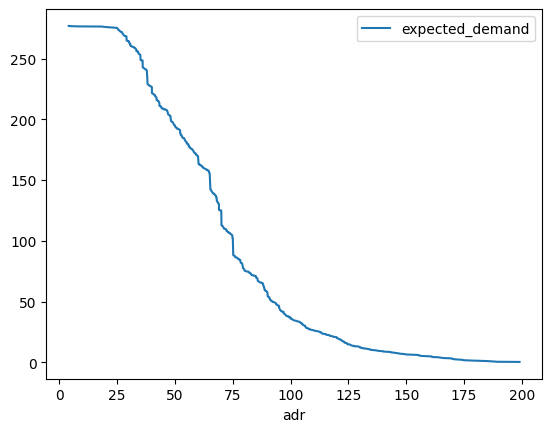

In [31]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_demand', kind='line')

# **Visualizing Expected Revenue vs. ADR**


<Axes: xlabel='adr'>

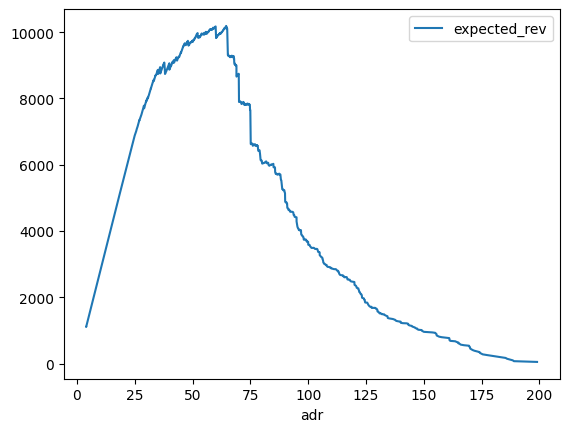

In [32]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_rev', kind='line')

In [33]:
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand,expected_rev
799,Friday,April,199.00,City Hotel,A,150.0,2,City Hotel,A,150.0,889,111.125,119.0,0.002250,0.267717,0.267717,53.275591
798,Friday,April,189.00,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.401575,75.897638
797,Friday,April,188.50,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.535433,100.929134
796,Friday,April,187.25,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.669291,125.324803
795,Friday,April,186.00,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.803150,149.385827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90871,Wednesday,September,12.00,City Hotel,A,150.0,1,City Hotel,A,150.0,1158,144.750,145.0,0.000864,0.125216,332.495827,3989.949930
90872,Wednesday,September,12.00,City Hotel,D,80.0,1,City Hotel,D,80.0,315,39.375,39.0,0.003175,0.123810,332.619637,3991.435644
90870,Wednesday,September,11.75,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,679,84.875,87.5,0.001473,0.128866,332.748503,3909.794910
90869,Wednesday,September,7.00,Resort Hotel,E,60.0,1,Resort Hotel,E,60.0,167,20.875,21.0,0.005988,0.125749,332.874251,2330.119760


# **Defining the Demand Curve Function**


In [34]:
# Define the demand curve function
def demand_curve(x, a, b, c, d, max_demand):
    """
    Compute the demand based on the price using the demand curve function.
    
    Parameters:
    - x: float or array-like, the price
    - a: float, parameter controlling the exponential decay
    - b: float, parameter controlling the rate of decay
    - c: float, parameter controlling the base demand
    - d: float, parameter controlling the shift
    - max_demand: float, the maximum demand limit
    
    Returns:
    - demand: float or array-like, the computed demand
    """
    # Calculate the initial demand
    demand = a * np.exp(-b * x) + c
    
    # Apply maximum demand limit
    demand = np.where(x <= max_demand, np.minimum(demand, max_demand), demand)
    
    # Add the shift parameter
    return demand + d

# **Fitting the Demand Curve Function**


In [35]:
from scipy.optimize import curve_fit

# Extract ADR and expected demand data
x_data = merged_df['adr'].values
y_data = merged_df['expected_demand'].values

# Define initial guess for the parameters
initial_guess = [1, 0.01, 1, 1, 100]

# Define bounds for the parameters
bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

# Fit the demand curve to the data
params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)

# Extract fitted parameters
a_fit, b_fit, c_fit, d_fit, max_demand = params

In [36]:
predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)

 # **Visualizing the Fitted Demand Curve**

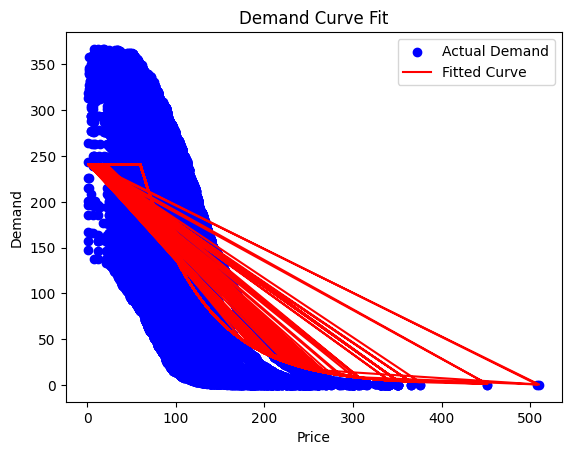

In [37]:
# Scatter plot of actual demand
plt.scatter(x_data, y_data, label='Actual Demand', color='blue')

# Line plot of the fitted demand curve
plt.plot(x_data, predicted_demand, label='Fitted Curve', color='red')

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand Curve Fit')

# Show the plot
plt.show()

# **Defining the Revenue Function**

In [38]:
def revenue(price):
    """
    Calculate the revenue based on the price and the demand curve.

    Parameters:
    price (float): The price at which to calculate the revenue.

    Returns:
    float: The calculated revenue.
    """
    return price * demand_curve(price, a_fit, b_fit, c_fit, d_fit, max_demand)

# **Optimizing Pricing Strategy**


In [39]:
from scipy.optimize import minimize_scalar

# Define the objective function to maximize revenue (minimize the negative revenue)
objective = lambda price: -revenue(price)

# Optimize the price using the bounded method
result = minimize_scalar(objective, bounds=(60, 180), method='bounded')

# Extract the optimal price and maximum revenue
optimal_price = result.x
max_revenue = -result.fun

# Calculate the number of rooms sold at the optimal price
room_sold = demand_curve(optimal_price, a_fit, b_fit, c_fit, d_fit, max_demand)

In [40]:
print(f"The optimal price to maximize revenue: ${optimal_price}")
print(f"The maximum revenue achievable: ${max_revenue}")
print(f"The expected number of rooms to sell: {room_sold}")

The optimal price to maximize revenue: $72.31630948616215
The maximum revenue achievable: $14659.054407395406
The expected number of rooms to sell: 202.70744610108235


# **Calculating Price for Desired Demand**

In [41]:
from scipy.optimize import brentq

def demand_to_price(num_rooms, a, b, c, d, max_demand):
    """
    Calculate the price required to achieve a specified number of rooms sold.

    Parameters:
    num_rooms (int): The number of rooms to be sold.
    a (float): Parameter of the demand curve.
    b (float): Parameter of the demand curve.
    c (float): Parameter of the demand curve.
    d (float): Parameter of the demand curve.
    max_demand (float): Maximum demand parameter of the demand curve.

    Returns:
    float: The price required to achieve the desired number of rooms sold.
    """
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)

    try:
        # Find the price where the demand equals num_rooms
        price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    except ValueError:
        # Fallback to a random price if no root is found
        price_range = (0, 200)
        price = np.random.uniform(*price_range)

    return price
# from scipy.optimize import brentq

# def demand_to_price(num_rooms, a, b, c, d, max_demand):
   
#     def root_func(x):
#         return num_rooms - (a * np.exp(-b * x) + c)
    
#     # Find the price using numerical root finding
#     price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    
#     return price

In [42]:
demand_to_price(50,a_fit,b_fit,c_fit,d_fit,max_demand)

173.54039376401687

# **Preparing Results DataFrame and Extracting Unique Values**

In [43]:
# Initialize an empty DataFrame with specified columns to store the results
results = pd.DataFrame(columns=['month', 'hotel', 'room_limit', 'room_type', 'dow', 'optimal_rate', 'expected_rn', 'expected_rev', 'optimal_rate_lim_inv'])

# Extract unique values for months and days of the week from the merged DataFrame
months = merged_df.month.unique()
dow = merged_df.dow.unique()

# Display the merged DataFrame
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand,expected_rev
799,Friday,April,199.00,City Hotel,A,150.0,2,City Hotel,A,150.0,889,111.125,119.0,0.002250,0.267717,0.267717,53.275591
798,Friday,April,189.00,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.401575,75.897638
797,Friday,April,188.50,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.535433,100.929134
796,Friday,April,187.25,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.669291,125.324803
795,Friday,April,186.00,City Hotel,A,150.0,1,City Hotel,A,150.0,889,111.125,119.0,0.001125,0.133858,0.803150,149.385827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90871,Wednesday,September,12.00,City Hotel,A,150.0,1,City Hotel,A,150.0,1158,144.750,145.0,0.000864,0.125216,332.495827,3989.949930
90872,Wednesday,September,12.00,City Hotel,D,80.0,1,City Hotel,D,80.0,315,39.375,39.0,0.003175,0.123810,332.619637,3991.435644
90870,Wednesday,September,11.75,Resort Hotel,A,150.0,1,Resort Hotel,A,150.0,679,84.875,87.5,0.001473,0.128866,332.748503,3909.794910
90869,Wednesday,September,7.00,Resort Hotel,E,60.0,1,Resort Hotel,E,60.0,167,20.875,21.0,0.005988,0.125749,332.874251,2330.119760


# **Optimization of Pricing and Revenue Forecasting**

In [44]:
for hotel in hotels:
    for room_type in room_types:
        for month in months:
            for day in dow:
                # Get data for the specific combination
                data_subset = merged_df[(merged_df['dow'] == day) & 
                                        (merged_df['hotel'] == hotel) & 
                                        (merged_df['room_type'] == room_type) & 
                                        (merged_df['month'] == month)].reset_index()
                
                if data_subset.empty:
                    continue

                # Remove outliers
                mean = data_subset['adr'].mean()
                std_dev = data_subset['adr'].std()
                data_subset['z_scores'] = np.abs((data_subset['adr'] - mean) / std_dev)
                data_subset = data_subset[data_subset['z_scores'] <= 2]

                # Fit demand curve
                x_data = data_subset['adr'].values
                y_data = data_subset['expected_demand'].values

                try:
                    initial_guess = [1, 0.01, 1, 1, data_subset['total_rns_median'].values[0]]
                    bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])
                    maxfev = 10000  # Increase the number of maximum function evaluations
                    params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess, maxfev=maxfev)
                except RuntimeError as e:
                    print(f"Error fitting demand curve for {hotel}, {room_type}, {month}, {day}: {e}")
                    continue

                a_fit, b_fit, c_fit, d_fit, max_demand = params

                # Optimize revenue
                def revenue(price):
                    return price * demand_curve(price, a_fit, b_fit, c_fit, d_fit, max_demand)

                objective = lambda price: -revenue(price)
                optimize = minimize_scalar(objective, bounds=(45, 200), method='bounded')
                optimal_price = optimize.x
                max_revenue = -optimize.fun
                expected_rns = demand_curve(optimal_price, a_fit, b_fit, c_fit, d_fit, max_demand)

                optimal_rate_lim_inv = demand_to_price(data_subset['room_limit'].mean(), a_fit, b_fit, c_fit, d_fit, max_demand)

                new_row = pd.DataFrame({'hotel': hotel,
                                        'room_type': room_type,
                                        'room_limit': data_subset['room_limit'].mean(),
                                        'month': month,
                                        'dow': day,
                                        'optimal_rate': optimal_price,
                                        'expected_rev': max_revenue,
                                        'expected_rn': expected_rns,
                                        'optimal_rate_lim_inv': optimal_rate_lim_inv}, index=[0])
                results = pd.concat([results, new_row], ignore_index=True)


Error fitting demand curve for City Hotel, E, March, Wednesday: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error fitting demand curve for Resort Hotel, D, May, Sunday: Optimal parameters not found: The maximum number of function evaluations is exceeded.


# **Results Cleanup and Formatting**


In [45]:
#clean up the results
results['optimal_rate'] = results['optimal_rate'].round()
results['optimal_rate_lim_inv'] = results['optimal_rate_lim_inv'].round()

results['expected_rn'] = results['expected_rn'].round().astype(int)
results['expected_rev'] = results['expected_rev'].round()
results

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,City Hotel,150.0,A,Friday,56.0,203,11252.0,64.0
1,April,City Hotel,150.0,A,Monday,54.0,191,10221.0,61.0
2,April,City Hotel,150.0,A,Saturday,60.0,217,12986.0,69.0
3,April,City Hotel,150.0,A,Sunday,58.0,221,12809.0,68.0
4,April,City Hotel,150.0,A,Thursday,54.0,229,12403.0,67.0
...,...,...,...,...,...,...,...,...,...
497,September,Resort Hotel,75.0,D,Saturday,67.0,254,17061.0,149.0
498,September,Resort Hotel,75.0,D,Sunday,62.0,320,19960.0,129.0
499,September,Resort Hotel,75.0,D,Thursday,65.0,305,19807.0,127.0
500,September,Resort Hotel,75.0,D,Tuesday,63.0,292,18437.0,123.0


In [46]:
results[(results['month'] == 'April') & (results['room_type'] == 'A')]

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,City Hotel,150.0,A,Friday,56.0,203,11252.0,64.0
1,April,City Hotel,150.0,A,Monday,54.0,191,10221.0,61.0
2,April,City Hotel,150.0,A,Saturday,60.0,217,12986.0,69.0
3,April,City Hotel,150.0,A,Sunday,58.0,221,12809.0,68.0
4,April,City Hotel,150.0,A,Thursday,54.0,229,12403.0,67.0
5,April,City Hotel,150.0,A,Tuesday,52.0,208,10913.0,63.0
6,April,City Hotel,150.0,A,Wednesday,56.0,223,12471.0,67.0
251,April,Resort Hotel,150.0,A,Friday,54.0,176,9527.0,63.0
252,April,Resort Hotel,150.0,A,Monday,55.0,161,8791.0,58.0
253,April,Resort Hotel,150.0,A,Saturday,63.0,175,11103.0,73.0


# **Generate and Display Combinations of Hotel and Room Types**

In [47]:
import itertools

# Define hotel and room types
hotel_types = ['Resort Hotel', 'City Hotel']
room_types = ['A', 'D', 'E']

# Generate all possible combinations of hotel and room types
combinations = list(itertools.product(hotel_types, room_types))

# Display the combinations
combinations
# Create a DataFrame from the combinations
combinations_df = pd.DataFrame(combinations, columns=['hotel', 'room_type'])

# Display the DataFrame
combinations_df

,hotel,room_type
0,Resort Hotel,A
1,Resort Hotel,D
2,Resort Hotel,E
3,City Hotel,A
4,City Hotel,D
5,City Hotel,E


# **Generate Date Range Data and Merge with Hotel-Room Combinations**


In [48]:
# Define month dictionary with month names and their corresponding indices
month_dict = {month: index for index, month in enumerate(pd.date_range('2020-01-01', periods=12, freq='M').strftime('%B'), 1)}

# Initialize an empty DataFrame
new_data = pd.DataFrame()

# Define the start and end dates
start_date = pd.Timestamp('2022-12-02')
end_date = pd.Timestamp('2025-01-31')

# Loop through each year and month to create a date range
for year in range(start_date.year, end_date.year + 1):
    for month in month_dict.values():
        if year == start_date.year and month < start_date.month:
            continue
        if year == end_date.year and month > end_date.month:
            continue
        
        # Define the start and end dates for the month
        month_start = pd.to_datetime(f'{year}-{month:02d}-01')
        month_end = (month_start + pd.offsets.MonthEnd(0))
        date_range = pd.date_range(month_start, month_end, freq='D')
        
        # Filter date range to include only dates within the specified range
        date_range = date_range[(date_range >= start_date) & (date_range <= end_date)]
        
        # Create a DataFrame from the date range
        df = pd.DataFrame(date_range, columns=['arrival_date'])
        df['dow'] = df['arrival_date'].dt.day_name()
        df['month'] = df['arrival_date'].dt.month_name()
        
        # Merge with hotel-room combinations
        result_df = df.assign(key=1).merge(combinations_df.assign(key=1), on='key').drop('key', axis=1)
        
        # Append to the new DataFrame
        new_data = pd.concat([new_data, result_df], ignore_index=True)

# Display the resulting DataFrame
new_data

,arrival_date,dow,month,hotel,room_type
0,2022-12-02,Friday,December,Resort Hotel,A
1,2022-12-02,Friday,December,Resort Hotel,D
2,2022-12-02,Friday,December,Resort Hotel,E
3,2022-12-02,Friday,December,City Hotel,A
4,2022-12-02,Friday,December,City Hotel,D
...,...,...,...,...,...
4747,2025-01-31,Friday,January,Resort Hotel,D
4748,2025-01-31,Friday,January,Resort Hotel,E
4749,2025-01-31,Friday,January,City Hotel,A
4750,2025-01-31,Friday,January,City Hotel,D


# **Merge Generated Date Data with Results Data**

In [49]:
# Merge the newly generated date data with the results DataFrame
final_data = pd.merge(new_data, results, how='left', on=['dow', 'hotel', 'room_type', 'month'])

# Display the resulting DataFrame
final_data

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-12-02,Friday,December,Resort Hotel,A,150.0,86.0,321.0,27666.0,120.0
1,2022-12-02,Friday,December,Resort Hotel,D,75.0,47.0,666.0,31295.0,144.0
2,2022-12-02,Friday,December,Resort Hotel,E,60.0,46.0,715.0,33229.0,162.0
3,2022-12-02,Friday,December,City Hotel,A,150.0,83.0,321.0,26785.0,122.0
4,2022-12-02,Friday,December,City Hotel,D,80.0,51.0,671.0,34238.0,150.0
...,...,...,...,...,...,...,...,...,...,...
4747,2025-01-31,Friday,January,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2025-01-31,Friday,January,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0
4749,2025-01-31,Friday,January,City Hotel,A,150.0,200.0,199.0,39735.0,68.0
4750,2025-01-31,Friday,January,City Hotel,D,80.0,71.0,395.0,28173.0,185.0


In [50]:
final_data['arrival_date'] = pd.to_datetime(final_data['arrival_date'])

In [51]:
final_data[final_data["optimal_rate_lim_inv"] > final_data["optimal_rate"]]

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-12-02,Friday,December,Resort Hotel,A,150.0,86.0,321.0,27666.0,120.0
1,2022-12-02,Friday,December,Resort Hotel,D,75.0,47.0,666.0,31295.0,144.0
2,2022-12-02,Friday,December,Resort Hotel,E,60.0,46.0,715.0,33229.0,162.0
3,2022-12-02,Friday,December,City Hotel,A,150.0,83.0,321.0,26785.0,122.0
4,2022-12-02,Friday,December,City Hotel,D,80.0,51.0,671.0,34238.0,150.0
...,...,...,...,...,...,...,...,...,...,...
4744,2025-01-30,Thursday,January,City Hotel,D,80.0,71.0,405.0,28666.0,185.0
4746,2025-01-31,Friday,January,Resort Hotel,A,150.0,99.0,296.0,29218.0,140.0
4747,2025-01-31,Friday,January,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2025-01-31,Friday,January,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0


In [52]:
final_data

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-12-02,Friday,December,Resort Hotel,A,150.0,86.0,321.0,27666.0,120.0
1,2022-12-02,Friday,December,Resort Hotel,D,75.0,47.0,666.0,31295.0,144.0
2,2022-12-02,Friday,December,Resort Hotel,E,60.0,46.0,715.0,33229.0,162.0
3,2022-12-02,Friday,December,City Hotel,A,150.0,83.0,321.0,26785.0,122.0
4,2022-12-02,Friday,December,City Hotel,D,80.0,51.0,671.0,34238.0,150.0
...,...,...,...,...,...,...,...,...,...,...
4747,2025-01-31,Friday,January,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2025-01-31,Friday,January,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0
4749,2025-01-31,Friday,January,City Hotel,A,150.0,200.0,199.0,39735.0,68.0
4750,2025-01-31,Friday,January,City Hotel,D,80.0,71.0,395.0,28173.0,185.0


In [53]:
4110/4752

0.86489898989899

In [54]:
final_data[final_data["expected_rn"] > final_data["room_limit"]]

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2022-12-02,Friday,December,Resort Hotel,A,150.0,86.0,321.0,27666.0,120.0
1,2022-12-02,Friday,December,Resort Hotel,D,75.0,47.0,666.0,31295.0,144.0
2,2022-12-02,Friday,December,Resort Hotel,E,60.0,46.0,715.0,33229.0,162.0
3,2022-12-02,Friday,December,City Hotel,A,150.0,83.0,321.0,26785.0,122.0
4,2022-12-02,Friday,December,City Hotel,D,80.0,51.0,671.0,34238.0,150.0
...,...,...,...,...,...,...,...,...,...,...
4747,2025-01-31,Friday,January,Resort Hotel,D,75.0,59.0,583.0,34289.0,180.0
4748,2025-01-31,Friday,January,Resort Hotel,E,60.0,59.0,568.0,33696.0,193.0
4749,2025-01-31,Friday,January,City Hotel,A,150.0,200.0,199.0,39735.0,68.0
4750,2025-01-31,Friday,January,City Hotel,D,80.0,71.0,395.0,28173.0,185.0


In [55]:
4417/4752

0.929503367003367

In [56]:
final_data.isna().sum()

arrival_date             0
dow                      0
month                    0
hotel                    0
room_type                0
room_limit              17
optimal_rate            17
expected_rn             17
expected_rev            17
optimal_rate_lim_inv    17
dtype: int64

# **Clean and Transform Final Dataset**


In [57]:
# Drop rows with missing values
final_data = final_data.dropna(axis=0)
# Convert 'arrival_date_transformed' in the backup data to datetime
data_backup['arrival_date_transformed'] = pd.to_datetime(data_backup['arrival_date_transformed'])

# Convert 'arrival_date' in final_data to datetime
final_data['arrival_date'] = pd.to_datetime(final_data['arrival_date'])

# **Data Merging and Cleanup for Revenue Optimization Booking**


In [60]:
# Merge data_backup with final_data
rev_opt_booking = pd.merge(data_backup, final_data, right_on=['arrival_date', 'hotel', 'room_type'], left_on=['arrival_date_transformed', 'hotel', 'reserved_room_type'], how='left')
# Save the merged DataFrame to a CSV file
rev_opt_booking.to_csv('rev_opt_booking.csv', index=False)

# Drop unnecessary columns
#rev_opt_booking.drop(['month_y', 'room_limit_y'], axis=1, inplace=True)
rev_opt_booking.drop(['room_limit_y'], axis=1, inplace=True)
# Rename columns for consistency
rev_opt_booking.rename(columns={"month_x": 'month', 'room_limit_x': 'room_limit'}, inplace=True)
rev_opt_booking["arrival_date"] = pd.to_datetime(rev_opt_booking["arrival_date"])
# Convert date columns to datetime format
rev_opt_booking["arrival_date_transformed"] = pd.to_datetime(rev_opt_booking["arrival_date_transformed"])
rev_opt_booking = pd.merge(data_backup, final_data, right_on=['arrival_date', 'hotel', 'room_type'], left_on=['arrival_date_transformed', 'hotel', 'reserved_room_type'], how='left')
rev_opt_booking.to_csv('rev_opt_booking.csv', index=False)

#rev_opt_booking.drop(['month_y', 'room_limit_y'], axis=1, inplace=True)
rev_opt_booking.drop(['room_limit_y'], axis=1, inplace=True)
rev_opt_booking.rename(columns={"month_x": 'month', 'room_limit_x': 'room_limit'}, inplace=True)
rev_opt_booking["arrival_date"] = pd.to_datetime(rev_opt_booking["arrival_date"])
rev_opt_booking["arrival_date_transformed"] = pd.to_datetime(rev_opt_booking["arrival_date_transformed"])
# Convert all column names to lowercase

rev_opt_booking.columns = map(lambda x: str(x).lower(), rev_opt_booking.columns)


In [61]:
rev_opt_booking.rename(columns={'arrival_date_year':'year',
                                'optimal_rate' : 'optimal_adr', 'optimal_rate_lim_inv': 'optimal_adr_limited',
                                'transcation_ids': 'booking_id', 'reservation_status_date_transformed': 'reservation_date'
                               }, inplace=True)

In [62]:
rev_opt_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68160 entries, 0 to 68159
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           68160 non-null  object        
 1   is_canceled                     68160 non-null  int8          
 2   lead_time                       68160 non-null  int16         
 3   reservation_status              68160 non-null  object        
 4   total_stay_nights               68160 non-null  int8          
 5   tally_days                      68160 non-null  float64       
 6   stays_in_weekend_nights         68160 non-null  int8          
 7   stays_in_week_nights            68160 non-null  int8          
 8   adults                          68160 non-null  int8          
 9   children                        68160 non-null  int8          
 10  babies                          68160 non-null  int8          
 11  to

In [63]:
KeyError: "['reservation_status_date', 'avg_rooms_per_night', 'reserved_room_type', 'tally_days', 'total_room_nights'] not found in axis"


# **Final Data Preparation and Storage**

In [64]:
def update_values(row):
    """
    Assigns a price based on hotel type and reserved room type.

    Parameters:
    row (pd.Series): A row of the DataFrame containing 'hotel' and 'reserved_room_type' columns.

    Returns:
    int or None: The assigned price based on the conditions or None if no match is found.
    """
    if row['hotel'] == 'City Hotel' and row['room_type'] == 'A':
        return 150
    elif row['hotel'] == 'City Hotel' and row['room_type'] == 'D':
        return 80
    elif row['hotel'] == 'City Hotel' and row['room_type'] == 'E':
        return 30
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'A':
        return 150
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'D':
        return 75
    elif row['hotel'] == 'Resort Hotel' and row['room_type'] == 'E':
        return 60
    else:
        return None  # Explicitly return None for rows that don't match any condition



In [66]:
# Update room_limit values using the predefined update_values function
rev_opt_booking['room_limit'] = rev_opt_booking.apply(update_values, axis=1)
# Drop columns that are not needed for final analysis
# rev_opt_booking = rev_opt_booking.drop(['reservation_status_date',  'avg_rooms_per_night','reserved_room_type', 'tally_days', 'total_room_nights'], axis=1)
# Convert 'adr' column to integer type
rev_opt_booking['adr'] = rev_opt_booking['adr'].astype(int)
# Reorder columns to ensure they appear in the desired sequence
rev_opt_booking = rev_opt_booking[['arrival_date', 'hotel', 'adr', 'is_canceled', 'lead_time',  'babies', 'children', 'country', 'customer_type', 'days_in_waiting_list', 'deposit_type', 'distribution_channel', 'dow', 'expected_rev','expected_rn', 'market_segment', 'meal', 'month', 'optimal_adr',  'optimal_adr_limited', 'previous_bookings_not_canceled', 'previous_cancellations', 'reservation_status','reservation_date', 'room_type', 'room_limit', 'stays_in_weekend_nights', 'stays_in_week_nights',  'total_guests', 'total_stay_nights']]
# Convert and format date columns to datetime strings
rev_opt_booking["reservation_date"] = pd.to_datetime(rev_opt_booking["reservation_date"]).dt.strftime("%Y-%m-%d %H:%M:%S")
rev_opt_booking["arrival_date"] = pd.to_datetime(rev_opt_booking["arrival_date"]).dt.strftime("%Y-%m-%d %H:%M:%S")
# Remove rows with missing values
rev_opt_booking["reservation_date"]
rev_opt_booking = rev_opt_booking.dropna(axis=0)
# Check for any remaining missing values
rev_opt_booking.isna().sum()
rev_opt_booking.shape
# Save the DataFrame to a table using Snowpark
df_model=my_session.createDataFrame(
        rev_opt_booking.values.tolist(),
        schema=rev_opt_booking.columns.tolist())
df_model.write.mode("overwrite").save_as_table("TTH_DB.TTH_REV_OPT_Schema.REV_OPT_OUTPUT")

KeyboardInterrupt: 

# **Expanding the DataFrame for Booking Details**

In [ ]:
expanded_dfc1 = pd.DataFrame()
data.columns = map(lambda x: str(x).lower(), data.columns)

# Iterate over each row in the original DataFrame
for _, row in data.iterrows():
    num_stay_dates = row['total_rns']
    try:
        # Create a row for each stay date
        expanded_bookingc1 = pd.DataFrame({
            'hotel': row['hotel'],
            'room_type': row['reserved_room_type'], 
            'market_segment': row['market_segment'],
            'deposit_type': row['deposit_type'],
            'meal': row['meal'],
            'distribution_channel': row['distribution_channel'],
            'customer_type': row['customer_type'],
            'arrival_date': pd.date_range(start=row['arrival_date_transformed'], periods=num_stay_dates),
            'total_rns': 1,
            'adr': row['adr'],
            'room_limit': row['room_limit']
        })
        
        # Append the stay date information to the new DataFrame
        expanded_dfc1 = pd.concat([expanded_dfc1, expanded_bookingc1], ignore_index=True)
    except ValueError as e:
        print(f"Error processing booking for {row['hotel']} on {row['arrival_date_transformed']} : {num_stay_dates} {e}")


# **Sorting and Resetting the Expanded DataFrame**

In [ ]:
# Sort the DataFrame by 'arrival_date' to ensure chronological order
expanded_dfc1 = expanded_dfc1.sort_values('arrival_date')
# Reset the index to ensure a clean, consecutive index
expanded_dfc1 = expanded_dfc1.reset_index(drop=True)
expanded_dfc1

# **Rounding the ADR Column**

In [ ]:
# Round the values in the 'adr' column to two decimal places
expanded_dfc1['adr']= np.round(expanded_dfc1['adr'], 2)
expanded_dfc1


# **Adding Day of the Week and Month Columns**

In [ ]:
# Add a column for the day of the week
expanded_dfc1['dow'] = expanded_dfc1.arrival_date.dt.strftime('%A')
# Add a column for the month
expanded_dfc1['month'] = expanded_dfc1.arrival_date.dt.strftime('%B')

# **Calculating Booking Frequency**

In [ ]:
# Aggregate booking data by hotel, room type, market segment, deposit type, meal, distribution channel, customer type, and arrival date
booking_frequency = expanded_dfc1.groupby(
    ['hotel', 'room_type', 'market_segment', 'deposit_type', 'meal', 
     'distribution_channel', 'customer_type', 'arrival_date'], 
    as_index=False, 
    sort=True
).agg({
    'adr': 'mean', 
    'room_limit': 'mean', 
    'total_rns': 'sum'
})

## **Sorting and Inspecting the Booking Frequency Data**

In [ ]:
# Sort the booking_frequency DataFrame by arrival_date, hotel, and room_type
booking_frequency = booking_frequency.sort_values(by=['arrival_date','hotel','room_type'], ascending=[True, True, True])
booking_frequency.info()

## **Formatting Arrival Date**

In [ ]:
# Convert arrival_date to datetime and format as YYYY-MM-DD HH:MM:SS
booking_frequency["arrival_date"] = pd.to_datetime(booking_frequency["arrival_date"]).dt.strftime("%Y-%m-%d %H:%M:%S")


In [ ]:
booking_frequency

## **Saving Data to Snowflake**


In [ ]:
# Convert booking_frequency DataFrame to a Snowflake DataFrame

df_inter=my_session.createDataFrame(
        booking_frequency.values.tolist(),
        schema=booking_frequency.columns.tolist())
df_inter.write.mode("overwrite").save_as_table("TTH_DB.TTH_REV_OPT_Schema.booking_frequency")

In [ ]:
booking_frequency.to_csv('./booking_frequency.csv', index=False)